In [74]:
import matplotlib.pyplot as plt # plotting
import numpy as np              # working with number arrays etc.
from netCDF4 import Dataset     # reading netcdf files
from numpy import trapz         # for integration

# all file paths: change according to file location
path_les="/Users/amrapallig/run/cvmix_analysis/les/"
path_adc="/Users/amrapallig/Desktop/cvmix/adc/convection/"
path_kpp="/Users/amrapallig/run/cvmix_analysis/les/KPP-CVMix/"
path_ke="/Users/amrapallig/run/cvmix_analysis/les/K-EPSILON-SG/"

In [75]:

# density calculation from given temp and salinity
def density_eos(t,s):
    density= 1026.0*(1.0-2e-4*(t-20)+8e-4*(s-35))
    return density


#rate of change of depth integrated potential energy calculation
def pot_energy2(temperature_0,temperature_t,salinity_0,salinity_t,depth,dtdz,dsdz,t=95):
    
     
   # depth=np.append(-0.5,depth)
    temp=20+dtdz*depth
    salt=35+dsdz*depth
    ind=np.where((depth)>=-100)  ##plots are weird with, 5 m doing worse than 10m if whole depth 100m is selected
    salt=salt[ind]
    temp=temp[ind]
    depth=depth[ind]
    density= density_eos(temp,salt)
    # depth integrated potential energy PE=density*9.81*depth
    area=trapz(density*9.81*depth,depth)
    PE_0=area  #/(depth[0]-depth[-1])

    
    #for final time
    #temp=temperature_t
    #salt=salinity_t

    temp=temperature_t[ind]
    salt=salinity_t[ind]
    density= density_eos(temp,salt)
    #plt.plot(density,depth)
    # depth integrated potential energy PE=density*9.81*depth
    # area under PE
    area=trapz(density*9.81*depth,depth)
    PE_t=area  #/(depth[0]-depth[-1])
    PE_rate_change=(PE_t-PE_0)/(3600*t)  # in Watt/m^2
    #print(PE_t)
    plt.plot(density,depth)

    return (PE_rate_change)


In [76]:

# density calculation from given temp and salinity
def density_eos(t,s):
    density= 1026.0*(1.0-2e-4*(t-20)+8e-4*(s-35))
    return density


#rate of change of depth integrated potential energy calculation
def pot_energy2_10monly(temperature_0,temperature_t,salinity_0,salinity_t,depth,dtdz,dsdz,t=95):
    
     
    depth=np.append(-0.5,depth)
    temp=20+dtdz*depth
    salt=35+dsdz*depth
    ind=np.where((depth)>=-100)  ##plots are weird with, 5 m doing worse than 10m if whole depth 100m is selected
    salt=salt[ind]
    temp=temp[ind]
    depth=depth[ind]
    density= density_eos(temp,salt)
    # depth integrated potential energy PE=density*9.81*depth
    area=trapz(density*9.81*depth,depth)
    PE_0=area  #/(depth[0]-depth[-1])

    
    #for final time
    #temp=temperature_t
    #salt=salinity_t
    temperature_t=np.append(temperature_t[0],temperature_t)
    salinity_t=np.append(salinity_t[0],salinity_t)
    temp=temperature_t[ind]
    salt=salinity_t[ind]
    density= density_eos(temp,salt)
    #plt.plot(density,depth)
    # depth integrated potential energy PE=density*9.81*depth
    # area under PE
    area=trapz(density*9.81*depth,depth)
    PE_t=area  #/(depth[0]-depth[-1])
    PE_rate_change=(PE_t-PE_0)/(3600*t)  # in Watt/m^2
    #print(PE_t)
    plt.plot(density,depth)

    return (PE_rate_change)


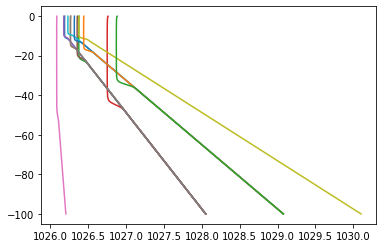

In [77]:
# time step
t = 95  # as KPP and KE have 95 hrs of data stratibg from zero
# range of time for averaging
t1 = t-12

# LES
#path_les="/Users/amrapalli/runs/cvmix/cvmix_analysis/les/"
results_les = {}
#vertical resolutions
#datasets = [1, 2, 5, 10] 
# list comprehension
file_names = [*[f"Cooling{x}" for x in [1, 2, 4, 16]], 
              *[f"Evap{x}" for x in [1, 4]],
              *[f"Strat{x}" for x in [1, 10, 20]],
              *[f"T1S{x}" for x in [0, 1, 3, 15]],
             ]

#file_names
for fn in file_names:
    les= Dataset(path_les+f'{fn}.nc', mode='r')

#         # compute pot
    
    if "Cooling" in fn:
        fn = fn.replace("Cooling", "c")
        dtdz=0.1; dsdz=0.0
    if "Evap" in fn:
        fn = fn.replace("Evap", "e")
        dtdz=0.0; dsdz=-0.025
    if "Strat" in fn:
        fn = fn.replace("Strat", "s")
        if "10" in fn:
            dtdz=0.1; dsdz=0.0
        elif "1" in fn:
            dtdz=0.01; dsdz=0.0
        elif "20" in fn:
            dtdz=0.2; dsdz=0.0
        else: 
            print("error")
    if "T1S" in fn:
        fn = fn.replace("T1S", "t1s")
        dtdz=0.05; dsdz=-0.025
    #print(fn,dtdz,dsdz)
    results_les[f"pe_{fn}_les"] = pot_energy2(les.variables["temp"][0,:],
                                              np.nanmean(les.variables["temp"][t1:t,:],axis=0),
                                              les.variables["salt"][0,:],
                                              np.nanmean(les.variables["salt"][t1:t,:],axis=0),
                                              les.variables['zm'][:],
                                              dtdz,
                                              dsdz)
#results_les

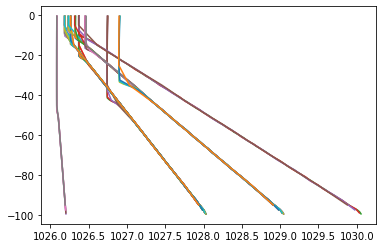

In [78]:
# ADC
#path_adc="/Users/amrapalli/runs/cvmix/cvmix_analysis/adc/convection/"
results_adc = {}
resolutions = [1, 2, 5, 10]
#resolutions = [10]
file_names = ["c1", "c2", "c4", "c16", 
              "e1", "e4", 
              "s1", "s10", "s20", 
              "t1s0", "t1s1", "t1s3", "t1s15"]

for fn in file_names:
    for n in resolutions:
        
        
        if "16"  in  fn and n == 1:
            mf = Dataset(path_adc+f'adcTurbulenceArrays_{fn}_{n}m_test3.nc', mode='r')
            fh = Dataset(path_adc+f'output.0001-01-01_00.00_{fn}_{n}m_test3.nc', mode='r')
        elif  "t1s15" == fn  and n == 1:  
            mf = Dataset(path_adc+f'adcTurbulenceArrays_{fn}_{n}m_test2_dtp5.nc', mode='r')
            fh = Dataset(path_adc+f'output.0001-01-01_00.00_{fn}_{n}m_test2_dtp5.nc', mode='r')
        else:
            mf = Dataset(path_adc+f'adcTurbulenceArrays_{fn}_{n}m_test2.nc', mode='r')  
            fh = Dataset(path_adc+f'output.0001-01-01_00.00_{fn}_{n}m_test2.nc', mode='r')

        if "c" in fn:
            dtdz=0.1; dsdz=0.0
        if "e" in fn:
            dtdz=0.0; dsdz=-0.025
        if "s" in fn:
            if "10" in fn:
                dtdz=0.1; dsdz=0.0
            elif "1" in fn:
                dtdz=0.01; dsdz=0.0
            elif "20" in fn:
                dtdz=0.2; dsdz=0.0
            else: 
                print("error")
        if "t1s" in fn:
            dtdz=0.05; dsdz=-0.025
                         
        # compute pot
        results_adc[f"pe_{fn}_{n}m"] = pot_energy2_10monly(mf.variables["temperature"][0,0,:],
                                                   np.nanmean(mf.variables["temperature"][t1:t,0,:],axis=0),
                                                   mf.variables["salinity"][0,0,:],
                                                  np.nanmean(mf.variables["salinity"][t1:t,0,:],axis=0),
                                                  fh.variables['zMid'][0,0,:],
                                                  dtdz,
                                                  dsdz)
#results_adc

Text(0.0004, 0, '(d)')

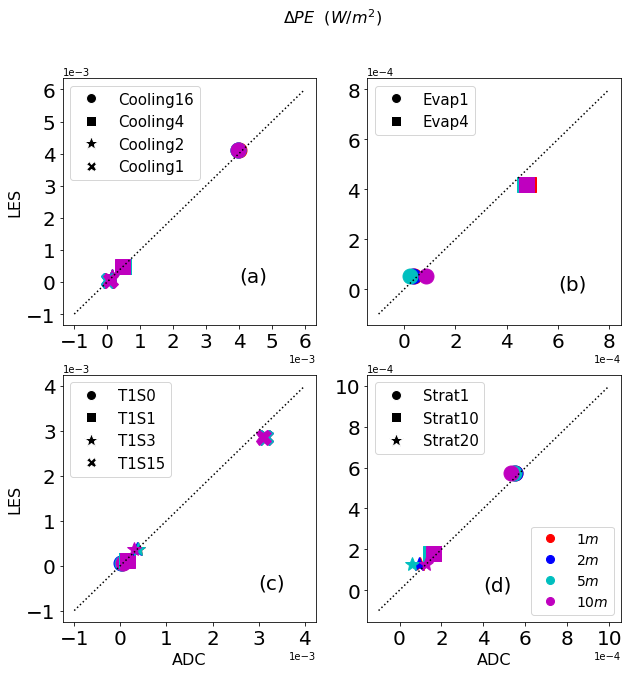

In [79]:
plt.figure(figsize=(10,10))
mks=15
plt.subplot(221)
plt.plot(results_adc["pe_c16_1m"],results_les["pe_c16_les"],'or',markersize=mks)
plt.plot(results_adc["pe_c16_2m"],results_les["pe_c16_les"],'ob',markersize=mks)
plt.plot(results_adc["pe_c16_5m"],results_les["pe_c16_les"],'oc',markersize=mks)
plt.plot(results_adc["pe_c16_10m"],results_les["pe_c16_les"],'om',markersize=mks)

plt.plot(results_adc["pe_c4_1m"],results_les["pe_c4_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_c4_2m"],results_les["pe_c4_les"],'sb',markersize=mks)
plt.plot(results_adc["pe_c4_5m"],results_les["pe_c4_les"],'sc',markersize=mks)
plt.plot(results_adc["pe_c4_10m"],results_les["pe_c4_les"],'sm',markersize=mks)

plt.plot(results_adc["pe_c2_1m"],results_les["pe_c2_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_c2_2m"],results_les["pe_c2_les"],'*b',markersize=mks)
plt.plot(results_adc["pe_c2_5m"],results_les["pe_c2_les"],'*c',markersize=mks)
plt.plot(results_adc["pe_c2_10m"],results_les["pe_c2_les"],'*m',markersize=mks)

plt.plot(results_adc["pe_c1_1m"],results_les["pe_c1_les"],'Xr',markersize=mks)
plt.plot(results_adc["pe_c1_2m"],results_les["pe_c1_les"],'Xb',markersize=mks)
plt.plot(results_adc["pe_c1_5m"],results_les["pe_c1_les"],'Xc',markersize=mks)
plt.plot(results_adc["pe_c1_10m"],results_les["pe_c1_les"],'Xm',markersize=mks)

#plt.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))
plt.plot([-0.001,6*1e-3],[-0.001,6*1e-3],':k')
legend1=plt.legend(["1m","2m","5m","10m"],loc=4)
plt.ylabel("LES",fontsize=16)
#plt.title("square: c1, circle: c2, star:c4, cross:c16",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cooling16',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Cooling4',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='Cooling2',markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='X', color='w', label='Cooling1',markerfacecolor='k', markersize=10)]
                      
legend=plt.legend(handles=legend_elements,loc=2,fontsize=15)
#plt.gca().add_artist(legend1)
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))
plt.text(4e-3, 0,"(a)",fontsize=20)


plt.subplot(222)
plt.plot(results_adc["pe_e1_1m"],results_les["pe_e1_les"],'or',markersize=mks)
plt.plot(results_adc["pe_e1_2m"],results_les["pe_e1_les"],'ob',markersize=mks)
plt.plot(results_adc["pe_e1_5m"],results_les["pe_e1_les"],'oc',markersize=mks)
plt.plot(results_adc["pe_e1_10m"],results_les["pe_e1_les"],'om',markersize=mks)

plt.plot(results_adc["pe_e4_1m"],results_les["pe_e4_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_e4_2m"],results_les["pe_e4_les"],'sb',markersize=mks)
plt.plot(results_adc["pe_e4_5m"],results_les["pe_e4_les"],'sc',markersize=mks)
plt.plot(results_adc["pe_e4_10m"],results_les["pe_e4_les"],'sm',markersize=mks)
legend1=plt.legend(["1m","2m","5m","10m"],loc=4)
#plt.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))
plt.plot([-0.0001,8*1e-4],[-0.0001,8*1e-4],':k')
#plt.title("square: e1, circle: e4",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Evap1',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Evap4',markerfacecolor='k', markersize=10)]
                  
                      
legend=plt.legend(handles=legend_elements,loc=2,fontsize=15)
#plt.gca().add_artist(legend1)
plt.ticklabel_format(axis="both", style="sci", scilimits=(-4,-4))
plt.text(6e-4, 0,"(b)",fontsize=20)


plt.subplot(223)
plt.plot(results_adc["pe_t1s0_1m"],results_les["pe_t1s0_les"],'or',markersize=mks)
plt.plot(results_adc["pe_t1s0_2m"],results_les["pe_t1s0_les"],'ob',markersize=mks)
plt.plot(results_adc["pe_t1s0_5m"],results_les["pe_t1s0_les"],'oc',markersize=mks)
plt.plot(results_adc["pe_t1s0_10m"],results_les["pe_t1s0_les"],'om',markersize=mks)

plt.plot(results_adc["pe_t1s1_1m"],results_les["pe_t1s1_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_t1s1_2m"],results_les["pe_t1s1_les"],'sb',markersize=mks)
plt.plot(results_adc["pe_t1s1_5m"],results_les["pe_t1s1_les"],'sc',markersize=mks)
plt.plot(results_adc["pe_t1s1_10m"],results_les["pe_t1s1_les"],'sm',markersize=mks)

plt.plot(results_adc["pe_t1s3_1m"],results_les["pe_t1s3_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_t1s3_2m"],results_les["pe_t1s3_les"],'*b',markersize=mks)
plt.plot(results_adc["pe_t1s3_5m"],results_les["pe_t1s3_les"],'*c',markersize=mks)
plt.plot(results_adc["pe_t1s3_10m"],results_les["pe_t1s3_les"],'*m',markersize=mks)

plt.plot(results_adc["pe_t1s15_1m"],results_les["pe_t1s15_les"],'Xr',markersize=mks)
plt.plot(results_adc["pe_t1s15_2m"],results_les["pe_t1s15_les"],'Xb',markersize=mks)
plt.plot(results_adc["pe_t1s15_5m"],results_les["pe_t1s15_les"],'Xc',markersize=mks)
plt.plot(results_adc["pe_t1s15_10m"],results_les["pe_t1s15_les"],'Xm',markersize=mks)

#plt.ticklabel_format(axis="both", style="sci", scilimits=(-1,-1))
plt.plot([-0.001,4*1e-3],[-0.001,4*1e-3],':k')
legend1=plt.legend(["1m","2m","5m","10m"],loc=4)
plt.ylabel("LES",fontsize=16)
plt.xlabel("ADC",fontsize=16)
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='T1S0',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='T1S1',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='T1S3',markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='X', color='w', label='T1S15',markerfacecolor='k', markersize=10)]
                      
legend=plt.legend(handles=legend_elements,loc=2,fontsize=15)
#plt.gca().add_artist(legend1)
plt.text(3e-3, -0.5e-3,"(c)",fontsize=20)


plt.subplot(224)
plt.plot(results_adc["pe_s1_1m"],results_les["pe_s1_les"],'or',markersize=mks)#, markerfacecolor='none')
plt.plot(results_adc["pe_s1_2m"],results_les["pe_s1_les"],'ob',markersize=mks)#, markerfacecolor='none')
plt.plot(results_adc["pe_s1_5m"],results_les["pe_s1_les"],'oc',markersize=mks)#, markerfacecolor='none')
plt.plot(results_adc["pe_s1_10m"],results_les["pe_s1_les"],'om',markersize=mks)#, markerfacecolor='none')

plt.plot(results_adc["pe_s10_1m"],results_les["pe_s10_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_s10_2m"],results_les["pe_s10_les"],'sb',markersize=mks)
plt.plot(results_adc["pe_s10_5m"],results_les["pe_s10_les"],'sc',markersize=mks)
plt.plot(results_adc["pe_s10_10m"],results_les["pe_s10_les"],'sm',markersize=mks)

plt.plot(results_adc["pe_s20_1m"],results_les["pe_s20_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_s20_2m"],results_les["pe_s20_les"],'*b',markersize=mks)
plt.plot(results_adc["pe_s20_5m"],results_les["pe_s20_les"],'*c',markersize=mks)
plt.plot(results_adc["pe_s20_10m"],results_les["pe_s20_les"],'*m',markersize=mks)

#plt.ticklabel_format(axis="both", style="sci", scilimits=(-2,-2))
plt.plot([-0.0001,1*1e-3],[-0.0001,1*1e-3],':k')

legend1=plt.legend(["1m","2m","5m","10m"],loc=4)
plt.xlabel("ADC",fontsize=16)
#plt.title("square: s1, circle: s10, star:s20",fontsize=14)
plt.suptitle("$\Delta PE$  $(W/m^2)$",fontsize=16)

#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-4,-4))


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from matplotlib.patches import Patch
from matplotlib.lines import Line2D


legend_elements2 = [ Line2D([0], [0], marker='o', color='w', label='$1 m$',markeredgecolor='r',markerfacecolor='r', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$2 m$',markeredgecolor='b',markerfacecolor='b', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$5 m$',markeredgecolor='c',markerfacecolor='c', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$10 m$',markeredgecolor='m',markerfacecolor='m', markersize=8)]

legend3=plt.legend(handles=legend_elements2,loc=4,fontsize=14)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Strat1',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Strat10',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='Strat20',markerfacecolor='k', markersize=15),]
                 
legend=plt.legend(handles=legend_elements,loc=2,fontsize=15)

plt.gca().add_artist(legend3)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(4e-4, 0,"(d)",fontsize=20)


In [80]:
relative_errors_adc = {}

# cooling
for les in [1, 2, 4, 16]:
    for adc in [1, 2, 5, 10]:
        numerator =  results_adc[f"pe_c{les}_{adc}m"]-results_les[f"pe_c{les}_les"] 
        relative_errors_adc[f"c{les}_{adc}m"] = numerator/results_les[f"pe_c{les}_les"]
        
#  Evap
for les in [1, 4]:
    for adc in [1, 2, 5, 10]:
        numerator =  results_adc[f"pe_e{les}_{adc}m"]-results_les[f"pe_e{les}_les"] 
        relative_errors_adc[f"e{les}_{adc}m"] = numerator/results_les[f"pe_e{les}_les"]

#  Strat
for les in [1, 10, 20]:
    for adc in [1, 2, 5, 10]:
        numerator =  results_adc[f"pe_s{les}_{adc}m"]-results_les[f"pe_s{les}_les"]
        relative_errors_adc[f"s{les}_{adc}m"] = numerator/results_les[f"pe_s{les}_les"]
        
#  T1S
for les in [0, 1, 3, 15]:
    for adc in [1, 2, 5, 10]:
        numerator =   results_adc[f"pe_t1s{les}_{adc}m"]-results_les[f"pe_t1s{les}_les"]
        relative_errors_adc[f"t1s{les}_{adc}m"] = numerator/results_les[f"pe_t1s{les}_les"]

(array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

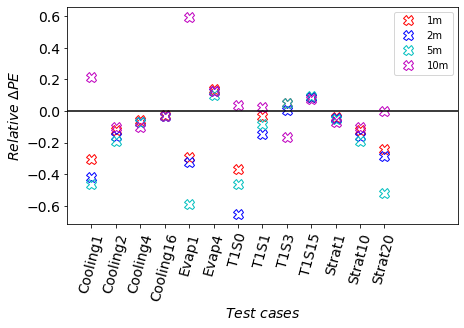

In [81]:
plt.figure(figsize=(7,4))
xaxis=np.arange(2,27,2)

datasets = [1, 2, 5, 10]
file_names = ["c1", "c2", "c4", "c16", 
              "e1", "e4", 
              "t1s0", "t1s1", "t1s3", "t1s15",
              "s1", "s10", "s20" ]

line_styles = ["Xr", "Xb", "Xc", "Xm"]


for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_adc[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)


plt.plot([0,32],[0,0],'-k')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26], ['Cooling1', 'Cooling2', 'Cooling4','Cooling16','Evap1','Evap4','T1S0','T1S1','T1S3','T1S15','Strat1','Strat10','Strat20'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
plt.xlabel("$Test$ $cases$",fontsize=14);plt.legend(["1m","2m","5m","10m"])
plt.xlim(0,32)
#plt.ylim(-0.5,0.5)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

Text(0.5, 0.98, 'ADC')

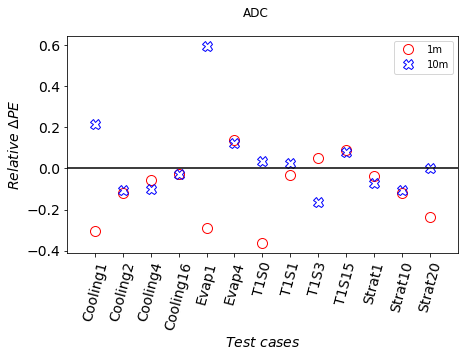

In [82]:
plt.figure(figsize=(7,4))
xaxis=np.arange(2,27,2)

datasets = [1,10]
file_names = ["c1", "c2", "c4", "c16", 
              "e1", "e4", 
              "t1s0", "t1s1", "t1s3", "t1s15",
              "s1", "s10", "s20" ]

#line_styles = ["Xr", "Xb", "Xc", "Xm"]
line_styles = ["or", "Xb" ]


for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_adc[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)


plt.plot([0,28],[0,0],'-k')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26], ['Cooling1', 'Cooling2', 'Cooling4','Cooling16','Evap1','Evap4','T1S0','T1S1','T1S3','T1S15','Strat1','Strat10','Strat20'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
plt.xlabel("$Test$ $cases$",fontsize=14);plt.legend(["1m","10m"])
plt.xlim(0,28)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.suptitle("ADC")

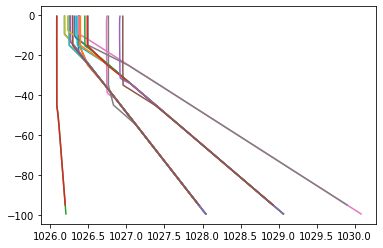

In [83]:
t=380 #95 hr
#t=360 #90 hr
#t1=288  #72 hr  % for 24 hr avg
t1=332  #83 hr # for 12 hr avg
#kpp
path_kpp="/Users/amrapallig/run/cvmix_analysis/les/KPP-CVMix/"

results_kpp = {}
file_names = [*[f"Cooling{x}" for x in [1, 2, 4, 16]], 
              *[f"Evap{x}" for x in [1, 4]],
              *[f"Strat{x}" for x in [1, 10, 20]],
              *[f"T1S{x}" for x in [0, 1, 3, 15]],
             ]
datasets = [1, 10]


for fn in file_names:
    mf1m = Dataset(path_kpp+f'VR1m/{fn}/gotm_out.nc', mode='r')
    mf10m = Dataset(path_kpp+f'VR10m/{fn}/gotm_out.nc', mode='r')
    if "Cooling" in fn:
        fn = fn.replace("Cooling", "c")
        dtdz=0.1; dsdz=0.0
    if "Evap" in fn:
        fn = fn.replace("Evap", "e")
        dtdz=0.0; dsdz=-0.025
    if "Strat" in fn:
        fn = fn.replace("Strat", "s")
        if "10" in fn:
            dtdz=0.1; dsdz=0.0
        elif "1" in fn:
            dtdz=0.01; dsdz=0.0
        elif "20" in fn:
            dtdz=0.2; dsdz=0.0
        else: 
            print("error",fn)
    if "T1S" in fn:
        fn = fn.replace("T1S", "t1s")
        dtdz=0.05; dsdz=-0.025


    # compute pot
    results_kpp[f"pe_{fn}_1m_kpp"] = pot_energy2_10monly(np.flip(mf1m.variables["temp"][0,:,0,0]),
                                             np.flip(np.nanmean(mf1m.variables["temp"][t1:t,:,0,0],axis=0)),
                                             np.flip(mf1m.variables["salt"][0,:,0,0]),
                                             np.flip(np.nanmean(mf1m.variables["salt"][t1:t,:,0,0],axis=0)),
                                             np.flip( mf1m.variables['z'][0,:,0,0]),
                                             dtdz,
                                             dsdz)
    results_kpp[f"pe_{fn}_10m_kpp"] = pot_energy2_10monly(np.flip(mf10m.variables["temp"][0,:,0,0]),
                                             np.flip(np.nanmean(mf10m.variables["temp"][t1:t,:,0,0],axis=0)),
                                             np.flip(mf10m.variables["salt"][0,:,0,0]),
                                             np.flip(np.nanmean(mf10m.variables["salt"][t1:t,:,0,0],axis=0)),
                                             np.flip(mf10m.variables['z'][0,:,0,0]),
                                             dtdz,
                                             dsdz)
#results_kpp

In [84]:
mf1m.variables["time"][332]/3600

83.0

In [85]:
relative_errors_kpp = {}

# cooling
for les in [1, 2, 4, 16]:
    for adc in [1,10]:
        numerator = results_kpp[f"pe_c{les}_{adc}m_kpp"]-results_les[f"pe_c{les}_les"] 
        relative_errors_kpp[f"c{les}_{adc}m"] = numerator/results_les[f"pe_c{les}_les"]
        
#  Evap
for les in [1, 4]:
    for adc in [1, 10]:
        numerator =  results_kpp[f"pe_e{les}_{adc}m_kpp"]-results_les[f"pe_e{les}_les"] 
        relative_errors_kpp[f"e{les}_{adc}m"] = numerator/results_les[f"pe_e{les}_les"]

#  Strat
for les in [1, 10, 20]:
    for adc in [1,10]:
        numerator =   results_kpp[f"pe_s{les}_{adc}m_kpp"]-results_les[f"pe_s{les}_les"]
        relative_errors_kpp[f"s{les}_{adc}m"] = numerator/results_les[f"pe_s{les}_les"]
        
#  T1S
for les in [0, 1, 3, 15]:
    for adc in [1,10]:
        numerator =  results_kpp[f"pe_t1s{les}_{adc}m_kpp"]-results_les[f"pe_t1s{les}_les"] 
        relative_errors_kpp[f"t1s{les}_{adc}m"] = numerator/results_les[f"pe_t1s{les}_les"]

Text(0.5, 0.98, '$KPP$')

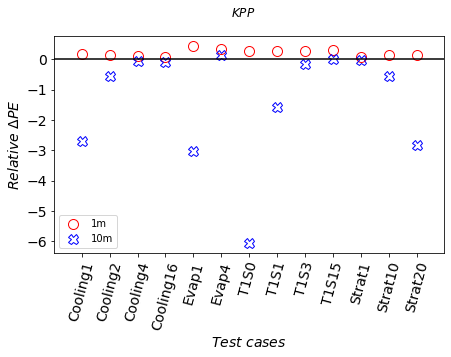

In [86]:
plt.figure(figsize=(7,4))
xaxis=np.arange(2,27,2)

datasets = [1, 10]
file_names = ["c1", "c2", "c4", "c16", 
              "e1", "e4", 
              "t1s0", "t1s1", "t1s3", "t1s15",
              "s1", "s10", "s20" ]

line_styles = ["or", "Xb" ]


for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_kpp[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)


plt.plot([0,28],[0,0],'-k')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26], ['Cooling1', 'Cooling2', 'Cooling4','Cooling16','Evap1','Evap4','T1S0','T1S1','T1S3','T1S15','Strat1','Strat10','Strat20'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
plt.xlabel("$Test$ $cases$",fontsize=14);plt.legend(["1m","10m"])
plt.xlim(0,28)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.suptitle("$KPP$")

{'pe_c1_1m_ke': 7.273670475472484e-05,
 'pe_c1_10m_ke': 9.706762433052063e-05,
 'pe_c2_1m_ke': 0.0001950026152993155,
 'pe_c2_10m_ke': 0.00018522023649243584,
 'pe_c4_1m_ke': 0.0005403181135175172,
 'pe_c4_10m_ke': 0.0003613120162347604,
 'pe_c16_1m_ke': 0.0042880894379875465,
 'pe_c16_10m_ke': 0.004249190434203511,
 'pe_e1_1m_ke': 7.334848404017806e-05,
 'pe_e1_10m_ke': 9.749451349353232e-05,
 'pe_e4_1m_ke': 0.0005474702916516546,
 'pe_e4_10m_ke': 0.0003645136849573481,
 'pe_s1_1m_ke': 0.0006006195534739578,
 'pe_s1_10m_ke': 0.0001799507659821831,
 'pe_s10_1m_ke': 0.0001950026152993155,
 'pe_s10_10m_ke': 0.00018522023649243584,
 'pe_s20_1m_ke': 0.00013892301662187827,
 'pe_s20_10m_ke': 0.0001858128945599174,
 'pe_t1s0_1m_ke': 6.121387537459882e-05,
 'pe_t1s0_10m_ke': 9.66324238052145e-05,
 'pe_t1s1_1m_ke': 0.00016119517220391168,
 'pe_t1s1_10m_ke': 0.00018510520283938848,
 'pe_t1s3_1m_ke': 0.00044625148159718655,
 'pe_t1s3_10m_ke': 0.00036301126152451276,
 'pe_t1s15_1m_ke': 0.00358782

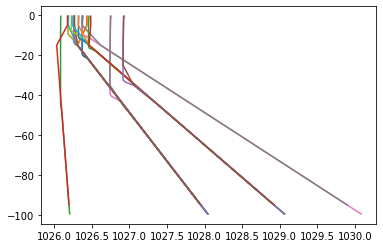

In [87]:
t=380 #95 hr
#t=360 #90 hr
t1=332 #83 hr #12 hr average

#ke


results_ke = {}
file_names = [*[f"Cooling{x}" for x in [1, 2, 4, 16]], 
              *[f"Evap{x}" for x in [1, 4]],
              *[f"Strat{x}" for x in [1, 10, 20]],
              *[f"T1S{x}" for x in [0, 1, 3, 15]],
             ]
datasets = [1, 10]


for fn in file_names:
    mf1m = Dataset(path_ke+f'VR1m/{fn}/gotm_out.nc', mode='r')
    mf10m = Dataset(path_ke+f'VR10m/{fn}/gotm_out.nc', mode='r')
    if "Cooling" in fn:
        fn = fn.replace("Cooling", "c")
        dtdz=0.1; dsdz=0.0
    if "Evap" in fn:
        fn = fn.replace("Evap", "e")
        dtdz=0.0; dsdz=-0.025
    if "Strat" in fn:
        fn = fn.replace("Strat", "s")
        if "10" in fn:
            dtdz=0.1; dsdz=0.0
        elif "1" in fn:
            dtdz=0.01; dsdz=0.0
        elif "20" in fn:
            dtdz=0.2; dsdz=0.0
        else: 
            print("error",fn)
    if "T1S" in fn:
        fn = fn.replace("T1S", "t1s")
        dtdz=0.05; dsdz=-0.025


    # compute pot
    results_ke[f"pe_{fn}_1m_ke"] = pot_energy2_10monly(np.flip(mf1m.variables["temp"][0,1:,0,0]),
                                             np.flip(np.nanmean(mf1m.variables["temp"][t1:t,1:,0,0],axis=0)),
                                             np.flip(mf1m.variables["salt"][0,1:,0,0]),
                                             np.flip(np.nanmean(mf1m.variables["salt"][t1:t,1:,0,0],axis=0)),
                                             np.flip(mf1m.variables['z'][0,1:,0,0]),
                                             dtdz,
                                             dsdz)
    results_ke[f"pe_{fn}_10m_ke"] = pot_energy2_10monly(np.flip(mf10m.variables["temp"][0,1:,0,0]),
                                             np.flip(np.nanmean(mf10m.variables["temp"][t1:t,1:,0,0],axis=0)),
                                             np.flip(mf10m.variables["salt"][0,1:,0,0]),
                                             np.flip(np.nanmean(mf10m.variables["salt"][t1:t,1:,0,0],axis=0)),
                                             np.flip(mf10m.variables['z'][0,1:,0,0]),
                                             dtdz,
                                             dsdz)
results_ke

In [88]:
relative_errors_ke = {}

# cooling
for les in [1, 2, 4, 16]:
    for adc in [1,10]:
        numerator = results_ke[f"pe_c{les}_{adc}m_ke"]-results_les[f"pe_c{les}_les"] 
        relative_errors_ke[f"c{les}_{adc}m"] = numerator/results_les[f"pe_c{les}_les"]
        
#  Evap
for les in [1, 4]:
    for adc in [1, 10]:
        numerator =  results_ke[f"pe_e{les}_{adc}m_ke"]-results_les[f"pe_e{les}_les"] 
        relative_errors_ke[f"e{les}_{adc}m"] = numerator/results_les[f"pe_e{les}_les"]

#  Strat
for les in [1, 10, 20]:
    for adc in [1,10]:
        numerator =   results_ke[f"pe_s{les}_{adc}m_ke"]-results_les[f"pe_s{les}_les"]
        relative_errors_ke[f"s{les}_{adc}m"] = numerator/results_les[f"pe_s{les}_les"]
        
#  T1S
for les in [0, 1, 3, 15]:
    for adc in [1,10]:
        numerator =  results_ke[f"pe_t1s{les}_{adc}m_ke"]-results_les[f"pe_t1s{les}_les"] 
        relative_errors_ke[f"t1s{les}_{adc}m"] = numerator/results_les[f"pe_t1s{les}_les"]
#relative_errors_ke        

Text(0.5, 0.98, '$k-\\epsilon$')

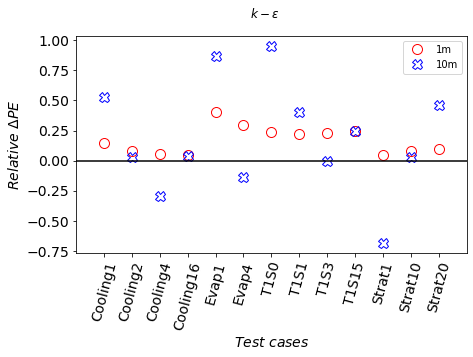

In [89]:
plt.figure(figsize=(7,4))
xaxis=np.arange(2,27,2)

datasets = [1, 10]
file_names = ["c1", "c2", "c4", "c16", 
              "e1", "e4", 
              "t1s0", "t1s1", "t1s3", "t1s15",
              "s1", "s10", "s20" ]

line_styles = ["or", "Xb", ]

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_ke[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)


plt.plot([0,28],[0,0],'-k')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26], ['Cooling1', 'Cooling2', 'Cooling4','Cooling16','Evap1','Evap4','T1S0','T1S1','T1S3','T1S15','Strat1','Strat10','Strat20'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
plt.xlabel("$Test$ $cases$",fontsize=14);plt.legend(["1m","10m"])
plt.xlim(0,28)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.suptitle("$k-\epsilon$")

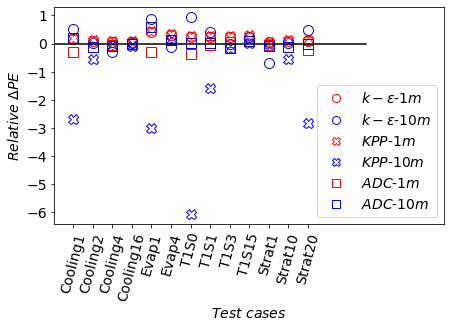

In [90]:
#all data in one plot for relative delta PE

plt.figure(figsize=(7,4))
xaxis=np.arange(2,27,2)

datasets = [1, 10]
file_names = ["c1", "c2", "c4", "c16", 
              "e1", "e4", 
              "t1s0", "t1s1", "t1s3", "t1s15",
              "s1", "s10", "s20" ]
line_styles1 = ["or", "ob", ]
line_styles2 = ["Xr", "Xb", ]
line_styles3 = ["sr", "sb", ]

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles1):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_ke[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles2):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_kpp[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles3):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_adc[f"{fn}_{d}m"], ls,markersize=10,markerfacecolor='none', linewidth=5)

plt.plot([0,32],[0,0],'-k')
plt.xticks([2,4,6,8,10,12,14,16,18,20,22,24,26], ['Cooling1', 'Cooling2', 'Cooling4','Cooling16','Evap1','Evap4','T1S0','T1S1','T1S3','T1S15','Strat1','Strat10','Strat20'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
plt.xlabel("$Test$ $cases$",fontsize=14);

plt.xlim(0,40)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

legend_elements2 = [ Line2D([0], [0], marker='o', color='w', label='$k-\epsilon$-$1 m$',markeredgecolor='r',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$k-\epsilon$-$10 m$',markeredgecolor='b',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='X', color='w', label='$KPP$-$1 m$',markeredgecolor='r',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='X', color='w', label='$KPP$-$10 m$',markeredgecolor='b',markerfacecolor='none', markersize=8),
                Line2D([0], [0], marker='s', color='w', label='$ADC$-$1 m$',markeredgecolor='r',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='s', color='w', label='$ADC$-$10 m$',markeredgecolor='b',markerfacecolor='none', markersize=8)]

legend3=plt.legend(handles=legend_elements2,fontsize=14)
#plt.ylim(-2,2)

(0.0, 40.0)

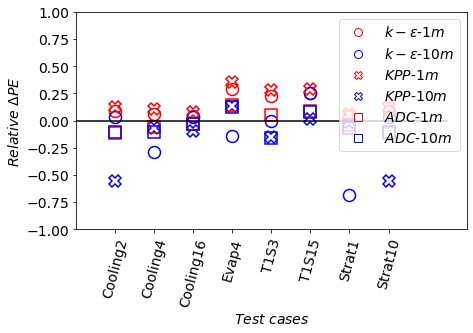

In [71]:
#all data in one plot for relative delta PE

plt.figure(figsize=(7,4))
xaxis=np.arange(2,27,2)*2

datasets = [1,10]
file_names = [ "c2","c4", "c16", 
               "e4", 
               "t1s3", "t1s15",
               "s1","s10" ]

line_styles1 = ["or", "ob", ]
line_styles2 = ["Xr", "Xb", ]
line_styles3 = ["sr", "sb", ]

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles1):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_ke[f"{fn}_{d}m"], ls,markersize=12,markerfacecolor='none', markeredgewidth=1.5)

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles2):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_kpp[f"{fn}_{d}m"], ls,markersize=12,markerfacecolor='none', markeredgewidth=1.5)

for fn, x in zip(file_names,xaxis):  
    for d, ls in zip(datasets, line_styles3):
        #print(x, f"{fn}_{d}m")
        plt.plot(x,relative_errors_adc[f"{fn}_{d}m"], ls,markersize=12,markerfacecolor='none', markeredgewidth=1.5)

plt.plot([0,38],[0,0],'-k')
plt.xticks([2*2,4*2,6*2,8*2,10*2,12*2,14*2,16*2], ['Cooling2', 'Cooling4','Cooling16','Evap4','T1S3','T1S15','Strat1','Strat10'],rotation=75,fontsize=14)
plt.ylabel("$Relative$ $\Delta PE$",fontsize=14)
plt.xlabel("$Test$ $cases$",fontsize=14);

#plt.xlim(0,55)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

legend_elements2 = [ Line2D([0], [0], marker='o', color='w', label='$k-\epsilon$-$1 m$',markeredgecolor='r',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='o', color='w', label='$k-\epsilon$-$10 m$',markeredgecolor='b',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='X', color='w', label='$KPP$-$1 m$',markeredgecolor='r',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='X', color='w', label='$KPP$-$10 m$',markeredgecolor='b',markerfacecolor='none', markersize=8),
                Line2D([0], [0], marker='s', color='w', label='$ADC$-$1 m$',markeredgecolor='r',markerfacecolor='none', markersize=8),
                  Line2D([0], [0], marker='s', color='w', label='$ADC$-$10 m$',markeredgecolor='b',markerfacecolor='none', markersize=8)]

legend3=plt.legend(handles=legend_elements2,fontsize=14)
plt.ylim(-1,1)
plt.xlim(0,40)

Text(0.0006, 0, '(h)')

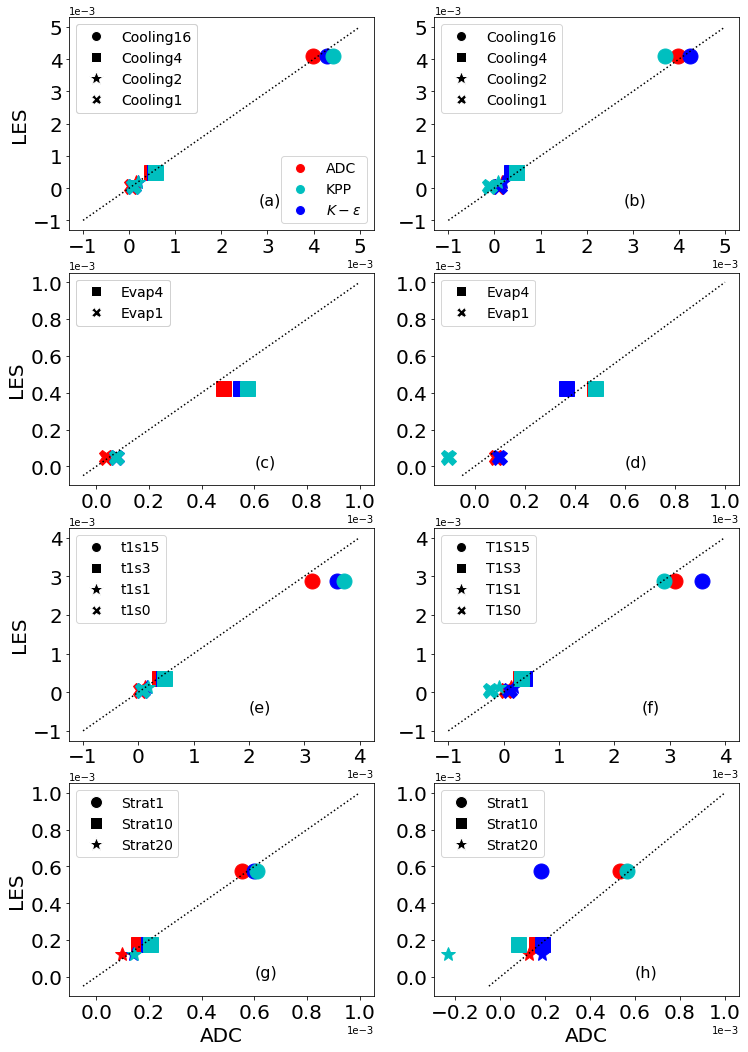

In [73]:
plt.figure(figsize=(12,18))
mks=15
mks1=12

plt.subplot(421)
plt.plot(results_adc["pe_c16_1m"],results_les["pe_c16_les"],'or',markersize=mks)
plt.plot(results_adc["pe_c4_1m"],results_les["pe_c4_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_c2_1m"],results_les["pe_c2_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_c1_1m"],results_les["pe_c1_les"],'Xr',markersize=mks)

plt.plot(results_ke["pe_c16_1m_ke"],results_les["pe_c16_les"],'ob',markersize=mks)
plt.plot(results_ke["pe_c4_1m_ke"],results_les["pe_c4_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_c2_1m_ke"],results_les["pe_c2_les"],'*b',markersize=mks)
plt.plot(results_ke["pe_c1_1m_ke"],results_les["pe_c1_les"],'Xb',markersize=mks)

plt.plot(results_kpp["pe_c16_1m_kpp"],results_les["pe_c16_les"],'oc',markersize=mks)
plt.plot(results_kpp["pe_c4_1m_kpp"],results_les["pe_c4_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_c2_1m_kpp"],results_les["pe_c2_les"],'*c',markersize=mks)
plt.plot(results_kpp["pe_c1_1m_kpp"],results_les["pe_c1_les"],'Xc',markersize=mks)

plt.plot([-0.001,5*1e-3],[-0.001,5*1e-3],':k')
legend1=plt.legend(["ADC","$K-\epsilon$","KPP"],loc=4, fontsize=14)
plt.ylabel("LES",fontsize=20)
#plt.xlabel("ADC",fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cooling16',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Cooling4',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='Cooling2',markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='X', color='w', label='Cooling1',markerfacecolor='k', markersize=10)]
                      
#plt.gca().add_artist(legend1)
plt.ylabel("LES",fontsize=20)
legend2=plt.legend(handles=legend_elements,loc=2,fontsize=14)

plt.gca().add_artist(legend2)


legend_elements = [Line2D([0], [0], marker='o', color='w', label='ADC',markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='KPP',markerfacecolor='c', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='$K-\epsilon$',markerfacecolor='b', markersize=10),]
                 
legend=plt.legend(handles=legend_elements,loc=4,fontsize=14)

plt.gca().add_artist(legend2)
plt.text(2.8e-3,-0.5e-3,"(a)", fontsize=16) 

plt.subplot(422)
plt.plot(results_adc["pe_c16_10m"],results_les["pe_c16_les"],'or',markersize=mks)
plt.plot(results_adc["pe_c4_10m"],results_les["pe_c4_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_c2_10m"],results_les["pe_c2_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_c1_10m"],results_les["pe_c1_les"],'Xr',markersize=mks)

plt.plot(results_ke["pe_c16_10m_ke"],results_les["pe_c16_les"],'ob',markersize=mks)
plt.plot(results_ke["pe_c4_10m_ke"],results_les["pe_c4_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_c2_10m_ke"],results_les["pe_c2_les"],'*b',markersize=mks)
plt.plot(results_ke["pe_c1_10m_ke"],results_les["pe_c1_les"],'Xb',markersize=mks)

plt.plot(results_kpp["pe_c16_10m_kpp"],results_les["pe_c16_les"],'oc',markersize=mks)
plt.plot(results_kpp["pe_c4_10m_kpp"],results_les["pe_c4_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_c2_10m_kpp"],results_les["pe_c2_les"],'*c',markersize=mks)
plt.plot(results_kpp["pe_c1_10m_kpp"],results_les["pe_c1_les"],'Xc',markersize=mks)



plt.plot([-0.001,5*1e-3],[-0.001,5*1e-3],':k')
#plt.xlabel("ADC",fontsize=14)
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cooling16',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='Cooling4',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='Cooling2',markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='X', color='w', label='Cooling1',markerfacecolor='k', markersize=10)]
                      
#plt.gca().add_artist(legend1)
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)



plt.text(2.8e-3,-0.5e-3,"(b)", fontsize=16) 


plt.subplot(423)
plt.plot(results_adc["pe_e4_1m"],results_les["pe_e4_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_e1_1m"],results_les["pe_e1_les"],'Xr',markersize=mks)

plt.plot(results_ke["pe_e4_1m_ke"],results_les["pe_e4_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_e1_1m_ke"],results_les["pe_e1_les"],'Xb',markersize=mks)

plt.plot(results_kpp["pe_e4_1m_kpp"],results_les["pe_e4_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_e1_1m_kpp"],results_les["pe_e1_les"],'Xc',markersize=mks)
plt.ylabel("LES",fontsize=20)



plt.plot([-0.00005,1*1e-3],[-0.00005,1*1e-3],':k')
#plt.xlabel("ADC",fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
from matplotlib.lines import Line2D
legend_elements = [
                   Line2D([0], [0], marker='s', color='w', label='Evap4',markerfacecolor='k', markersize=10),
                
                    Line2D([0], [0], marker='X', color='w', label='Evap1',markerfacecolor='k', markersize=10)]
                      
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)
plt.gca().add_artist(legend2)

plt.text(0.6e-3,0,"(c)", fontsize=16) 

plt.subplot(424)
plt.plot(results_adc["pe_e4_10m"],results_les["pe_e4_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_e1_10m"],results_les["pe_e1_les"],'Xr',markersize=mks)

plt.plot(results_ke["pe_e4_10m_ke"],results_les["pe_e4_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_e1_10m_ke"],results_les["pe_e1_les"],'Xb',markersize=mks)

plt.plot(results_kpp["pe_e4_10m_kpp"],results_les["pe_e4_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_e1_10m_kpp"],results_les["pe_e1_les"],'Xc',markersize=mks)



plt.plot([-0.00005,1*1e-3],[-0.00005,1*1e-3],':k')
#plt.xlabel("ADC",fontsize=14)
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))

plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
from matplotlib.lines import Line2D
legend_elements = [
                   Line2D([0], [0], marker='s', color='w', label='Evap4',markerfacecolor='k', markersize=10),
                
                    Line2D([0], [0], marker='X', color='w', label='Evap1',markerfacecolor='k', markersize=10)]
                      
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)
plt.text(0.6e-3,0,"(d)", fontsize=16) 

##########################################################

plt.subplot(425)
plt.plot(results_adc["pe_t1s15_1m"],results_les["pe_t1s15_les"],'or',markersize=mks)
plt.plot(results_adc["pe_t1s3_1m"],results_les["pe_t1s3_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_t1s1_1m"],results_les["pe_t1s1_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_t1s0_1m"],results_les["pe_t1s0_les"],'Xr',markersize=mks)

plt.plot(results_ke["pe_t1s15_1m_ke"],results_les["pe_t1s15_les"],'ob',markersize=mks)
plt.plot(results_ke["pe_t1s3_1m_ke"],results_les["pe_t1s3_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_t1s1_1m_ke"],results_les["pe_t1s1_les"],'*b',markersize=mks)
plt.plot(results_ke["pe_t1s0_1m_ke"],results_les["pe_t1s0_les"],'Xb',markersize=mks)

plt.plot(results_kpp["pe_t1s15_1m_kpp"],results_les["pe_t1s15_les"],'oc',markersize=mks)
plt.plot(results_kpp["pe_t1s3_1m_kpp"],results_les["pe_t1s3_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_t1s1_1m_kpp"],results_les["pe_t1s1_les"],'*c',markersize=mks)
plt.plot(results_kpp["pe_t1s0_1m_kpp"],results_les["pe_t1s0_les"],'Xc',markersize=mks)

plt.ylabel("LES",fontsize=20)


plt.plot([-0.001,4*1e-3],[-0.001,4*1e-3],':k')
#plt.xlabel("ADC",fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='t1s15',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='t1s3',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='t1s1',markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='X', color='w', label='t1s0',markerfacecolor='k', markersize=10)]
                      
#plt.gca().add_artist(legend1)
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)
plt.text(2e-3,-0.5e-3,"(e)", fontsize=16) 


plt.subplot(426)
plt.plot(results_adc["pe_t1s15_10m"],results_les["pe_t1s15_les"],'or',markersize=mks)
plt.plot(results_adc["pe_t1s3_10m"],results_les["pe_t1s3_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_t1s1_10m"],results_les["pe_t1s1_les"],'*r',markersize=mks)
plt.plot(results_adc["pe_t1s0_10m"],results_les["pe_t1s0_les"],'Xr',markersize=mks)

plt.plot(results_ke["pe_t1s15_10m_ke"],results_les["pe_t1s15_les"],'ob',markersize=mks)
plt.plot(results_ke["pe_t1s3_10m_ke"],results_les["pe_t1s3_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_t1s1_10m_ke"],results_les["pe_t1s1_les"],'*b',markersize=mks)
plt.plot(results_ke["pe_t1s0_10m_ke"],results_les["pe_t1s0_les"],'Xb',markersize=mks)

plt.plot(results_kpp["pe_t1s15_10m_kpp"],results_les["pe_t1s15_les"],'oc',markersize=mks)
plt.plot(results_kpp["pe_t1s3_10m_kpp"],results_les["pe_t1s3_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_t1s1_10m_kpp"],results_les["pe_t1s1_les"],'*c',markersize=mks)
plt.plot(results_kpp["pe_t1s0_10m_kpp"],results_les["pe_t1s0_les"],'Xc',markersize=mks)



plt.plot([-0.001,4*1e-3],[-0.001,4*1e-3],':k')
#plt.xlabel("ADC",fontsize=14)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='T1S15',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='s', color='w', label='T1S3',markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='*', color='w', label='T1S1',markerfacecolor='k', markersize=15),
                    Line2D([0], [0], marker='X', color='w', label='T1S0',markerfacecolor='k', markersize=10)]
                      
#plt.gca().add_artist(legend1)
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)
plt.text(2.5e-3,-0.5e-3,"(f)", fontsize=16) 


#############################################################
plt.subplot(427)
plt.plot(results_adc["pe_s1_1m"],results_les["pe_s1_les"],'or',markersize=mks)
plt.plot(results_adc["pe_s10_1m"],results_les["pe_s10_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_s20_1m"],results_les["pe_s20_les"],'*r',markersize=mks)

plt.plot(results_ke["pe_s1_1m_ke"],results_les["pe_s1_les"],'ob',markersize=mks)
plt.plot(results_ke["pe_s10_1m_ke"],results_les["pe_s10_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_s20_1m_ke"],results_les["pe_s20_les"],'*b',markersize=mks)

plt.plot(results_kpp["pe_s1_1m_kpp"],results_les["pe_s1_les"],'oc',markersize=mks)
plt.plot(results_kpp["pe_s10_1m_kpp"],results_les["pe_s10_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_s20_1m_kpp"],results_les["pe_s20_les"],'*c',markersize=mks)

plt.ylabel("LES",fontsize=20)


plt.plot([-0.00005,1*1e-3],[-0.00005,1*1e-3],':k')
plt.xlabel("ADC",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Strat1',markerfacecolor='k', markersize=mks1),
                   Line2D([0], [0], marker='s', color='w', label='Strat10',markerfacecolor='k', markersize=mks1),
                   Line2D([0], [0], marker='*', color='w', label='Strat20',markerfacecolor='k', markersize=mks)]
                   
                      
#plt.gca().add_artist(legend1)
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)

plt.ylabel("LES",fontsize=20)
plt.text(0.6e-3,0,"(g)", fontsize=16) 




plt.subplot(428)
plt.plot(results_adc["pe_s1_10m"],results_les["pe_s1_les"],'or',markersize=mks)
plt.plot(results_adc["pe_s10_10m"],results_les["pe_s10_les"],'sr',markersize=mks)
plt.plot(results_adc["pe_s20_10m"],results_les["pe_s20_les"],'*r',markersize=mks)

plt.plot(results_ke["pe_s1_10m_ke"],results_les["pe_s1_les"],'ob',markersize=mks)
plt.plot(results_ke["pe_s10_10m_ke"],results_les["pe_s10_les"],'sb',markersize=mks)
plt.plot(results_ke["pe_s20_10m_ke"],results_les["pe_s20_les"],'*b',markersize=mks)

plt.plot(results_kpp["pe_s1_10m_kpp"],results_les["pe_s1_les"],'oc',markersize=mks)
plt.plot(results_kpp["pe_s10_10m_kpp"],results_les["pe_s10_les"],'sc',markersize=mks)
plt.plot(results_kpp["pe_s20_10m_kpp"],results_les["pe_s20_les"],'*c',markersize=mks)



plt.plot([-0.00005,1*1e-3],[-0.00005,1*1e-3],':k')
plt.xlabel("ADC",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20) 
#plt.title("square: t1s0, circle: t1s1, star:t1s3, cross:t1s15",fontsize=14)
#plt.xscale("log")
#plt.yscale("log")
plt.ticklabel_format(axis="both", style="sci", scilimits=(-3,-3))


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Strat1',markerfacecolor='k', markersize=mks1),
                   Line2D([0], [0], marker='s', color='w', label='Strat10',markerfacecolor='k', markersize=mks1),
                   Line2D([0], [0], marker='*', color='w', label='Strat20',markerfacecolor='k', markersize=mks)]
                   
                      
#plt.gca().add_artist(legend1)
legend2=plt.legend(handles=legend_elements,loc=2, fontsize=14)

plt.text(0.6e-3,0,"(h)", fontsize=16) 





